# Predict slab dip

Predict the average slab dip, $\theta_{\mathrm{av}}$, of subducting oceanic lithosphere using the following relation,

$$
    \theta_{\mathrm{av}} q_v = A (v_c + v_t) \rho' h_{\mathrm{plate}} + B
$$

where $h_{\mathrm{plate}}$ is the thickness of the subducting plate calculated by plate models of lithospheric cooling (from [Grose, 2012](https://doi.org/10.1016/j.epsl.2012.03.037)), $q_v$ is the rate of volatile flux into newly-forming oceanic lithosphere at mid-ocean ridges, $\rho'$ is a buoyancy parameter related to the density of the crust relative to the mantle lithosphere, $v_c$ is the convergence velocity, $v_t$ is the rate of trench migration, and $A$ and $B$ are coefficients obtained from a weighted linear regression.
Using the present-day configuration of subduction boundaries and slab dips obtained from the Slab2 model ([Hayes _et al._, 2018](https://doi.org/10.1126/science.aat4723)), we obtain $A = 0.8$ and $B = 9$ with standard deviations of $\sigma_A = 0.17$ and $\sigma_B = 4.6$.


## Dependencies

To run this notebook some dependencies are required:

- [pygplates](https://www.gplates.org/download/)
- [gplately](https://github.com/GPlates/gplately)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/installing.html) (for mapping)


## Data packages

Plate reconstructions and corresponding age grids and seafloor spreading rate grids can be downloaded through `GPlately` (an object-oriented interface to `pyGPlates`) to calculate slab dip. Alternatively, these may be downloaded from https://www.earthbyte.org/gplates-2-3-software-and-data-sets/

The slab dip calculation has been tested on [Clennett _et al._ (2020)](https://doi.org/10.1029/2020GC009117) and [Müller _et al._ (2019)](https://doi.org/10.1029/2018TC005462) plate reconstructions but should also work fine for other plate reconstructions.


#### References

- Grose, C. J. (2012). Properties of oceanic lithosphere: Revised plate cooling model predictions. Earth and Planetary Science Letters, 333–334, 250–264. https://doi.org/10.1016/j.epsl.2012.03.037
- Hayes, G. P., Moore, G. L., Portner, D. E., Hearne, M., Flamme, H., Furtney, M., & Smoczyk, G. M. (2018). Slab2, a comprehensive subduction zone geometry model. Science, 362(6410), 58–61. https://doi.org/10.1126/science.aat4723
- Clennett, E. J., Sigloch, K., Mihalynuk, M. G., Seton, M., Henderson, M. A., Hosseini, K., et al. (2020). A Quantitative Tomotectonic Plate Reconstruction of Western North America and the Eastern Pacific Basin. Geochemistry, Geophysics, Geosystems, 21(8), 1–25. https://doi.org/10.1029/2020GC009117
- Müller, R. D., Zahirovic, S., Williams, S. E., Cannon, J., Seton, M., Bower, D. J., et al. (2019). A Global Plate Model Including Lithospheric Deformation Along Major Rifts and Orogens Since the Triassic. Tectonics, 38(6), 1884–1907. https://doi.org/10.1029/2018TC005462

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import gplately

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from scipy.stats import gaussian_kde
from scipy.spatial import cKDTree
from scipy import ndimage

In [2]:
# Call GPlately's DataServer object and download the plate model
gdownload = gplately.download.DataServer("Clennett2020")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

In [3]:
extent_globe = [-180,180,-90,90]

## Get kinematic data

Extract plate kinematic data for the present-day configuration of subduction zones to calculate the dip angle of subducting slabs.

Seafloor age grids and spreading rate grids are downloaded from the EarthByte webdav server.

In [4]:
def calc_rho(h_LIP, h_m):
    rho_LIP = 2700
    rho_c = 2900
    rho_m = 3315
    rho_a = 3370
    h_c = 7e3
    rho_mean = (rho_c*h_c + rho_m*h_m + rho_LIP*h_LIP)/(h_c+h_m+h_LIP)
    rho_crust = (rho_c*h_c + rho_LIP*h_LIP)/(h_c + h_LIP)
    return rho_mean/(rho_m - rho_crust)

def plate_influx(u, d, T, c, v):
    u = np.abs(u)
    A = 0.8807
    B_u = 0.262
    B_d = 0.3589
    B_T = -0.00029097
    B_c = 0.0075
    B_v = 0.0054
    C_v = 0.000035532
    F = A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref) + \
         C_v*(v**2 - v_ref**2)
    return F

u_ref = 3.0
d_ref = 1.504
T_ref = 1350.0
c_ref = 19.0
v_ref = 100.0


In [7]:
reconstruction_time = 0

subduction_data = model.tesselate_subduction_zones(reconstruction_time,
                                                   tessellation_threshold_radians=np.radians(0.5),
                                                   ignore_warnings=True,
                                                   output_subducting_absolute_velocity_components=True)

subduction_lon     = subduction_data[:,0]
subduction_lat     = subduction_data[:,1]
subduction_angle   = subduction_data[:,3]
subduction_norm    = subduction_data[:,7]
subduction_pid_sub = subduction_data[:,8]
subduction_pid_over= subduction_data[:,9]
subduction_length  = np.radians(subduction_data[:,6]) * gplately.EARTH_RADIUS * 1e3 # in metres
subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
subduction_migration   = np.fabs(subduction_data[:,4])*1e-2 * np.cos(np.radians(subduction_data[:,5]))
subduction_plate_vel = subduction_data[:,10]

# remove entries that have "negative" subduction
# this occurs when the subduction obliquity is greater than 90 degrees
subduction_convergence = np.clip(subduction_convergence, 0, 1e99)

# sample AgeGrid
age_grid = gdownload.get_age_grid(reconstruction_time)
age_raster = gplately.Raster(array=age_grid.copy(), extent=extent_globe)
age_raster.fill_NaNs(overwrite=True) # fill in NaN values
age_interp = age_raster.interpolate(subduction_lon, subduction_lat) # interpolate to trenches
thickness = gplately.tools.plate_isotherm_depth(age_interp)

# sample spreadrate grid
spreadrate_grid = gdownload.get_spreading_rate_grid(reconstruction_time)
spreadrate_raster = gplately.Raster(array=spreadrate_grid, extent=extent_globe)
spreadrate_raster.fill_NaNs(overwrite=True)
spreadrate_interp = spreadrate_raster.interpolate(subduction_lon, subduction_lat)

# calculate subduction volume rate - m * m * m/yr
subduction_vol_rate = thickness*subduction_length*subduction_convergence # integrated along subduction len
subduction_vol_rate *= 1e-9 # convert m^3/yr to km^3/yr

# get the ratio of convergence velocity to trench migration
vratio = (subduction_convergence + subduction_migration)/(subduction_convergence + 1e-22)
vratio[subduction_plate_vel < 0] *= -1
vratio = np.clip(vratio, 0.0, 1.0)

# calculate density of the plate
rho_c = 2900
rho_m = 3315
rho_a = 3370
h_c = 7e3
h_m = np.clip(thickness - h_c, 0, 1e99)
rho_prime = calc_rho(0.0, h_m)

coeff_a, coeff_b = 0.75, 9
theta_qv = coeff_a*(subduction_convergence*vratio)*thickness*rho_prime*1e-3 + coeff_b
volatile_flux = plate_influx(0.5*spreadrate_interp/10, d_ref, T_ref, c_ref, 120) #t/m/yr
subduction_dip = theta_qv/volatile_flux


print("mean plate thickness = {:.2f} m".format(thickness.mean()))
print("mean subduction segment length = {:.2f} m".format(subduction_length.mean()))
print("mean subduction convergence rate = {:.4f} m/yr".format(subduction_convergence.mean()))
print("mean subduction volume rate = {:.4f} km^3/yr".format(subduction_vol_rate.mean()))
print("mean volatile flux = {:.4f} t/m/yr".format(volatile_flux.mean()))
print("total subduction volume rate = {:.4f} km^3/yr".format(subduction_vol_rate.sum()))

mean plate thickness = 74545.60 m
mean subduction segment length = 40759.96 m
mean subduction convergence rate = 0.0383 m/yr
mean subduction volume rate = 0.1157 km^3/yr
mean volatile flux = 0.8275 t/m/yr
total subduction volume rate = 184.1464 km^3/yr


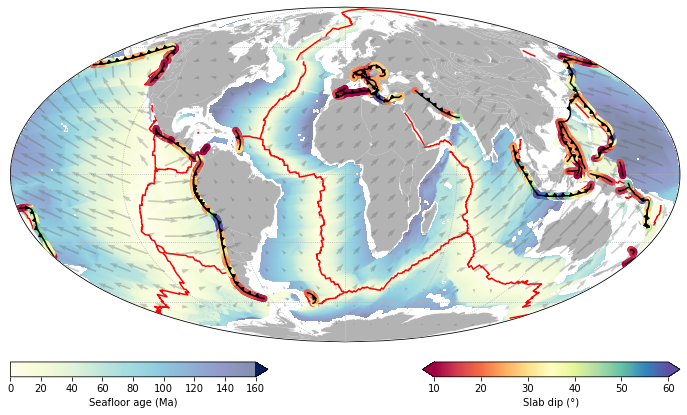

In [10]:
# Create a figure
fig = plt.figure(figsize=(12,7))
gs = GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

ax = fig.add_subplot(gs[0,:], projection=ccrs.Mollweide(central_longitude=0))
ax.set_global()

im = ax.imshow(age_grid, extent=extent_globe, cmap='YlGnBu', origin='lower', alpha=0.5,
               vmin=0, vmax=160, transform=ccrs.PlateCarree(), zorder=1)


gplot.plot_ridges_and_transforms(ax, color='r', zorder=3)
gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none', zorder=3)
gplot.plot_trenches(ax, zorder=9)
gplot.plot_subduction_teeth(ax, zorder=9)

sc0 = ax.scatter(subduction_lon, subduction_lat, c=subduction_dip, cmap='Spectral', vmin=10, vmax=60,
                 transform=ccrs.PlateCarree(), rasterized=True, zorder=8)

ax.gridlines(linestyle=':')


cax1 = fig.add_subplot(gs[1,0])
cax2 = fig.add_subplot(gs[1,1])

# fig.colorbar(im, shrink=0.4, label='Slab depth (km)')
fig.colorbar(sc0, cax=cax2, orientation='horizontal', label='Slab dip (°)', extend='both')
fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')
fig.savefig("slab_dip_{:04d}Ma.png".format(int(gplot.time)), dpi=300, bbox_inches='tight')